# overview of campaign deployments

In [1]:
import os

%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

# cognac data and tools
#import cognac.insitu as iu
import pynsitu as pin

In [2]:
# select campaign

root_dir = "/Users/aponte/Current_Projects/taos/campagnes/taos0/drifters0"
yaml = "taos_drifters0.yaml"

cp = pin.campaign(os.path.join(root_dir,yaml))

0-4351896
0-4351908
0-4352049
0-4351904
0-4352175
0-4352044
ctd_hydrophone
ship_hydrophone
ship_parceque


In [3]:
dr = cp.load('drifters.nc', toframe=True)

ship = dict(ship_hydrophone=cp.load('ship_hydrophone', toframe=True),
            ship_parceque=cp.load('ship_parceque', toframe=True),
           )
ctd = dict(ctd_hydrophone=cp.load('ctd_hydrophone'))
wind = cp.load("arome.nc")

dr.head()

,time,GPS Confidence,GPS Fail Counter,GpsQuality,latitude,longitude,x,y,u,v,velocity,deployment
id,,,,,,,,,,,,
0-4351896,2022-05-11 05:10:00,0.0,0.0,3.0,49.340097,-0.244161,-9536.329049,364.344050,0.161021,-0.108625,0.194235,d0
0-4351896,2022-05-11 05:20:00,0.0,0.0,3.0,49.339620,-0.240921,-9300.996664,310.834559,0.392221,-0.089182,0.402232,d0
0-4351896,2022-05-11 05:30:00,0.0,0.0,3.0,49.339238,-0.238421,-9119.384311,268.100720,0.302687,-0.071223,0.310954,d0
0-4351896,2022-05-11 05:40:00,0.0,0.0,3.0,49.338809,-0.236179,-8956.491419,220.120617,0.271488,-0.079967,0.283020,d0
0-4351896,2022-05-11 05:50:00,0.0,0.0,3.0,49.338380,-0.233990,-8797.520145,172.151659,0.264952,-0.079948,0.276751,d0


---
### time line

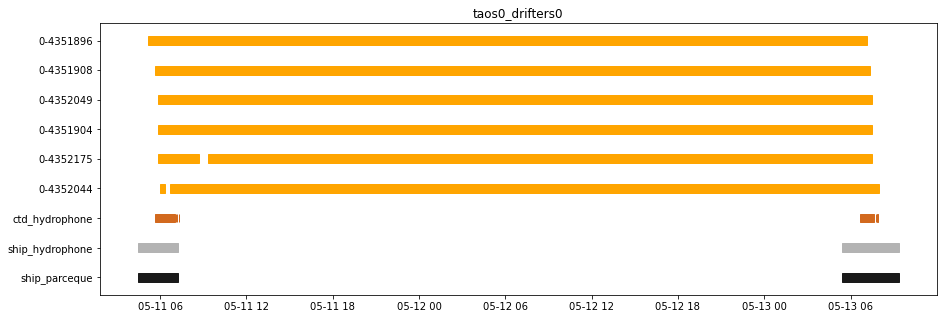

In [4]:
cp.timeline(legend=None)

---

### maps

/Users/aponte/.miniconda3/envs/cognac/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/Users/aponte/.miniconda3/envs/cognac/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


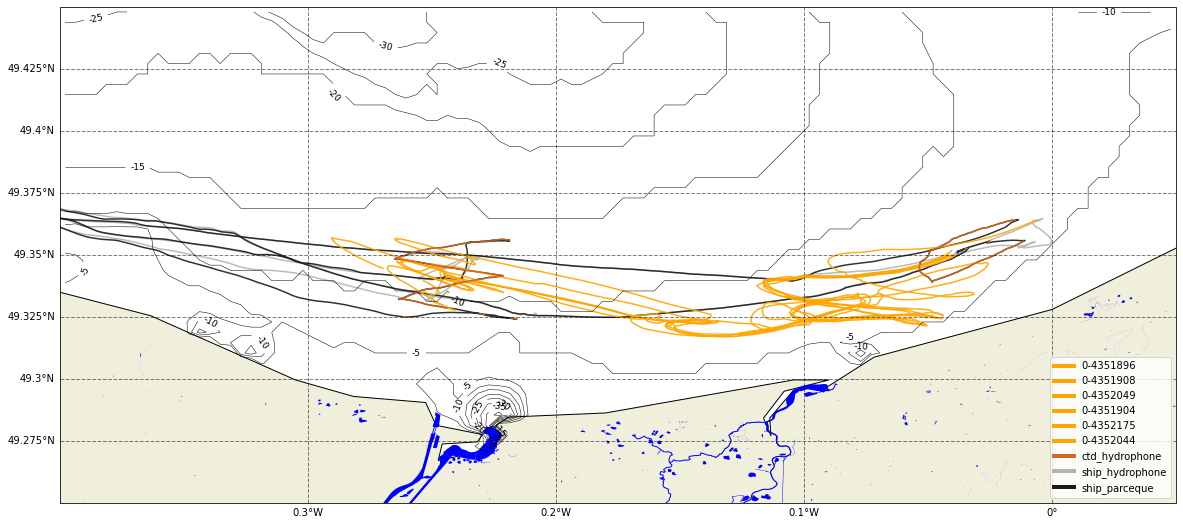

In [5]:
fig, ax, crs = cp.plot_map(coast="bseine", land=None, rivers="bseine", figsize=(20,10))

for uname, unit in cp.items():
    if "ship" in uname:
        s = ship[uname]
        for d, df in s.items():
            ax.plot(df.longitude, df.latitude, color=cp[uname]["color"], alpha=0.9,
                    transform=crs, label=uname+", "+d, zorder=0)
        continue
    if "ctd" in uname:
        c = ctd[uname]
        for d, df in c.items():
            ax.plot(df.longitude, df.latitude, color=cp[uname]["color"], alpha=0.9,
                    transform=crs, label=uname+", "+d, zorder=1)
        continue
    if "0-4" in uname:
        _df = dr.loc[uname]
        for d in _df["deployment"].unique():
            _dfd = _df.loc[_df.deployment==d].sort_values("time").set_index("time")
            ax.plot(_dfd.longitude, _dfd.latitude, color=cp[uname]["color"], alpha=0.9,
                    transform=crs, label=uname+", "+d, zorder=1)
        continue
            
    for d in unit:
        line=False
        yshift=0.
        label=uname+', '+d.label
        #if unit=='ctd':
        #    line=False
        #else:
        #    line=True
        #if unit=='source':
        #    yshift=2
        #else:
        #    yshift=0.
        d.plot_on_map(ax, line=line, label=label, color=unit['color'], yshift=yshift)

cp.add_legend(ax, loc=4)

In [6]:
# store bathymetric contours prior to folium plots
if False:
    pin.store_bathy_contours(cp.bathy["label"], 
                             os.path.join(cp.pathp, 'bathy_contours.geojson'),
                             levels=cp.bathy["levels"],
                            )

In [6]:
#cp.map(overwrite_contours=True)
cp.map(zoom=11, ignore=["ship_hydrophone", "ship_parceque"])

---

## movie


In [8]:

def make_movie(cp, tstart, tend,
               drifters=None,
               ship=None,
               wind=None,
               ctd=None,
               bounds=None,
              ):
    """ Make a movie
    """
    
    from tqdm import tqdm
    
    t_range = pd.date_range(tstart, tend, freq='10T')
    del_t = pd.Timedelta('1H')

    plt.switch_backend('agg')

    fig_dir = os.path.join(cp.pathp, 'figs/')

    i=0
    for t in tqdm(t_range):

        fig, ax, crs = cp.plot_map(figsize=(10,10), bounds=bounds, 
                                   coast="bseine", land=None, rivers="bseine",
        )

        # ship
        if ship is not None:
            for u, s in ship.items():
                for d, sd in s.items():
                    _s = sd.loc[t-del_t:t]
                    if _s.index.size>0:
                        ax.plot(_s['longitude'], _s['latitude'], lw=2, color='0.5', alpha=.8)
                        
        # wind
        if wind is not None:
            _di = 2
            _ds = (wind.interp(time=t).isel(longitude=slice(0,None,_di),latitude=slice(0,None,_di))
                  )
            q = _ds.plot.quiver(x="longitude", y="latitude", u="u10m", v="v10m", scale=1e2, transform=crs, zorder=-2)
            qk = ax.quiverkey(q, 0.1, 0.9, 10, '10 m/s', transform=crs, color="r",
                              labelpos='W', coordinates='axes', zorder=10)            
                
        # drifters
        if drifters is not None:
            #ids = dr.index.unique()
            ids = [u for u in cp if  "0-435" in u] # prefered as if leads to correct color ordering in legend
            colors = pin.get_cmap_colors(len(ids))
            for idx, c in zip(ids, colors):
                df = dr.loc[idx]
                for d in df["deployment"].unique():
                    _df = df.loc[df.deployment==d].set_index("time")
                    _df = _df.loc[t-del_t:t]
                    if _df.index.size>0:
                        ax.plot(_df.longitude, _df.latitude, color=c,  #cp[idx]["color"]
                                transform=crs, label=f"{idx}, {d}", lw=2)
                        ax.plot(_df.longitude[-1], _df.latitude[-1], color=c, #cp[idx]["color"]
                                marker="*", markeredgecolor="k", markeredgewidth=.5,
                                transform=crs, label=f"{idx}, {d}", lw=2, markersize=10)

        cp.add_legend(ax, loc=4, colors={idx: c for idx, c in zip(ids, colors)})
        ax.set_title(cp.name+'  '+str(t))

        figname = fig_dir+'fig_t%05d' %(i)+'.png'
        _ = fig.savefig(figname, dpi=150, facecolor='w', bbox_inches = 'tight')
        _ = fig.clf()
        
        i+=1

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [11]:
### taos0 - drifters0
tstart = '2022-05-11 05:00:00'
#tend = '2022-05-11 09:00:00'
tend = '2022-05-13 10:00:00'
bounds = None
bounds = [-.3, .05, 49.25, 49.45]

make_movie(cp, tstart, tend, drifters=dr, ship=ship, wind=wind, bounds=bounds)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 319/319 [30:21<00:00,  5.71s/it]


---

### folium tests

In [ ]:
import folium
from matplotlib.colors import cnames
from folium.plugins import MeasureControl, MousePosition

In [ ]:
folium.GeoJson?

In [ ]:
folium.features.GeoJsonPopup?

In [ ]:
tiles='Stamen Terrain'
tiles='Cartodb Positron'

m = folium.Map(location=[cp.lat_mid, cp.lon_mid],
               width='80%',
               height='80%',
               zoom_start=11,
               tiles=tiles,
               titles='my title', 
               attr="attribution",
              )

contours_geojson = insi.utils.load_bathy_contours()
tooltip = folium.GeoJsonTooltip(fields=['title'], aliases=['depth'], localize=True)
popup = folium.GeoJsonPopup(fields=['title'], aliases=['depth'], localize=False)

#folium.Popup(
def style_func(feature):
    return {'color':   feature['properties']['stroke'], #colorscale(feature['properties']['level-value']),
            'weight':  3, #x['properties']['stroke-width'],
            #'fillColor': x['properties']['fill'],
            'opacity': 1.,
            #'popup': 'depth '+feature['properties']['title'],
           }

folium.GeoJson(
    contours_geojson,
    name='geojson',
    style_function=style_func,
    tooltip=tooltip,
    popup=popup,
).add_to(m)

for uname, u in cp.items():
    for d in u:
        folium.Polygon([(d.start.lat, d.start.lon), (d.end.lat, d.end.lon)],
                       tooltip=uname+' '+d.label+'<br>'+str(d.start.time)+'<br>'+str(d.end.time),
                       color=cnames[u['color']],
                       dash_array='10 20',
                       opacity=.5
                      ).add_to(m)
        folium.Circle((d.start.lat, d.start.lon),
                      tooltip=uname+' '+d.label+'<br>'+str(d.start.time),
                      radius=2*1e2,
                      color=cnames[u['color']],
                     ).add_to(m)
        folium.Circle((d.end.lat, d.end.lon),
                      tooltip=uname+' '+d.label+'<br>'+str(d.end.time),
                      radius=1e2,
                      color=cnames[u['color']],
                     ).add_to(m)

MeasureControl().add_to(m)
MousePosition().add_to(m)

folium.features.DivIcon

m

In [ ]:
folium.plugins.FloatImage?

In [ ]:
folium.features.DivIcon?